In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
import pandas as pd

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline



In [2]:
#Data wrangling

counts = pd.read_csv('data/FremontBridge.csv', index_col='Date', parse_dates=True)
weather = pd.read_csv('data/BicycleWeather.csv', index_col='DATE', parse_dates=True)

<ipython-input-4-b77b36e0890e>:19: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  days = (date - pd.datetime(2000, 12, 21)).days


(8.0, 17.0)

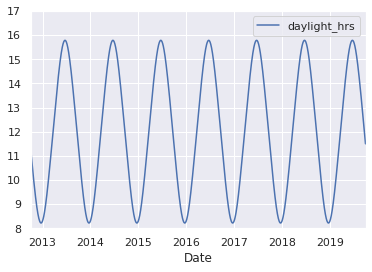

In [4]:
daily = counts.resample('d').sum()
daily['Total'] = daily.sum(axis=1)
daily = daily[['Total']] # remove other columns

days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
for i in range(7):
    daily[days[i]] = (daily.index.dayofweek == i).astype(float)
    
# add an indicator about holiday
from pandas.tseries.holiday import USFederalHolidayCalendar
cal = USFederalHolidayCalendar()
holidays = cal.holidays('2012', '2016')
daily = daily.join(pd.Series(1, index=holidays, name='holiday'))
# replace missing data with 0
daily['holiday'].fillna(0, inplace=True)  

def hours_of_daylight(date, axis=23.44, latitude=47.61):
    """Compute the hours of daylight for the given date"""
    days = (date - pd.datetime(2000, 12, 21)).days
    m = (1. - np.tan(np.radians(latitude))
         * np.tan(np.radians(axis) * np.cos(days * 2 * np.pi / 365.25)))
    return 24. * np.degrees(np.arccos(1 - np.clip(m, 0, 2))) / 180.

daily['daylight_hrs'] = list(map(hours_of_daylight, daily.index))
daily[['daylight_hrs']].plot()
plt.ylim(8, 17)


In [5]:
# temperatures are in 1/10 deg C; convert to C
weather['TMIN'] /= 10
weather['TMAX'] /= 10
weather['Temp (C)'] = 0.5 * (weather['TMIN'] + weather['TMAX'])

# precip is in 1/10 mm; convert to inches
weather['PRCP'] /= 254
weather['dry day'] = (weather['PRCP'] == 0).astype(int)

daily = daily.join(weather[['PRCP', 'Temp (C)', 'dry day']])
# how='left' means calling frame’s index 
# daily = daily.join(weather[['PRCP', 'Temp (C)', 'dry day']], how='left', lsuffix='_left', rsuffix='_right')


In [6]:
# number of years passed
daily['annual'] = (daily.index - daily.index[0]).days / 365.

In [8]:
from sklearn.model_selection import cross_val_score
# Drop any rows with null values
daily.dropna(axis=0, how='any', inplace=True)

column_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun', 'holiday',
                'daylight_hrs', 'PRCP', 'dry day', 'Temp (C)', 'annual']
X = daily[column_names]
y = daily['Total']

model = LinearRegression(fit_intercept=False)
cross_val_score(model,X,y, cv=10)
#model.fit(X, y)
#daily['predicted'] = model.predict(X)

array([0.76236871, 0.74794215, 0.77221239, 0.84538276, 0.7355564 ,
       0.76066698, 0.82227323, 0.74830747, 0.7751928 , 0.72185004])